1. Chargement et Prétraitement du Dataset


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# Chargement des données
from google.colab import files
uploaded = files.upload()

# Load the dataframe
file_name = next(iter(uploaded))
df = pd.read_csv(file_name)

Saving stock_market_dataset.csv to stock_market_dataset.csv


In [3]:
df.head()

,unix,date,symbol,open,high,low,close,Volume XRP,Volume USDT,ema_10,ema_30,rsi
1320,1.526520e+12,2018-05-17,XRP-USDT,0.70942,0.71200,0.64820,0.65849,10070061.14,6897498.182,0.727153,0.802368,20.978705
1319,1.526600e+12,2018-05-18,XRP-USDT,0.65849,0.68255,0.64600,0.67766,10140675.13,6745876.692,0.718155,0.794322,24.603934
1318,1.526690e+12,2018-05-19,XRP-USDT,0.67698,0.69139,0.66110,0.67339,6854397.75,4624460.531,0.710016,0.786520,21.970530
1317,1.526770e+12,2018-05-20,XRP-USDT,0.67483,0.70659,0.66800,0.69940,8055673.92,5558451.016,0.708085,0.780900,29.179148
1316,1.526860e+12,2018-05-21,XRP-USDT,0.69940,0.70500,0.66666,0.67612,7908213.57,5420030.289,0.702274,0.774140,30.455572


In [5]:
# Conversion et tri par date
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Calcul des indicateurs techniques
df['ema_10'] = df['close'].ewm(span=10, adjust=False).mean()
df['ema_30'] = df['close'].ewm(span=30, adjust=False).mean()

# Calcul du RSI
delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['rsi'] = 100 - (100 / (1 + rs))

# Suppression des NaN (dûs aux indicateurs)
df = df.dropna()

# Sélection des features et target
features = ['open', 'high', 'low', 'close', 'volume', 'ema_10', 'ema_30', 'rsi']
target = 'close'

# Ajustez les noms des colonnes selon votre dataset
features = ['open', 'high', 'low', 'close', 'Volume USDT', 'ema_10', 'ema_30', 'rsi']  # Remplacez 'volume' par 'Volume USDT'
target = 'close'

# Normalisation MinMax
scaler = MinMaxScaler()
scaler_target = MinMaxScaler()

# Sélectionnez uniquement les colonnes qui existent
existing_features = [f for f in features if f in df.columns]
df[existing_features] = scaler.fit_transform(df[existing_features])
df[target] = scaler_target.fit_transform(df[[target]])

 2. Création des Séquences pour LSTM

In [6]:
sequence_length = 60  # 60 jours historiques pour prédire le jour suivant

def create_sequences(data, features, target, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length][features].values)
        y.append(data.iloc[i+sequence_length][target])
    return np.array(X), np.array(y)

X, y = create_sequences(df, features, target, sequence_length)

# Découpage chronologique (80% train, 10% val, 10% test)
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print(f"Shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Shapes - Train: (988, 60, 8), Val: (123, 60, 8), Test: (124, 60, 8)


Fonction create_sequences :

    X : Contient des blocs de 60 jours d'historique.

    y : Contient le prix du jour suivant à prédire.

    Exemple : Si votre data a 1000 jours, vous aurez 940 séquences (1000 - 60).

Découpage Train/Val/Test :

    80% train : Pour apprendre.

    10% val : Pour ajuster le modèle.

    10% test : Pour évaluer la performance finale.

 3. Définir le Modèle LSTM avec Dropout

In [7]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.4),  # Dropout augmenté pour réduire l'overfitting
        LSTM(64),
        Dropout(0.4),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_lstm_model((X_train.shape[1], X_train.shape[2]))

# Callbacks
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True),
    TensorBoard(log_dir=os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S")))
]

# Entraînement
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - loss: 0.0205 - mae: 0.0908 - val_loss: 0.0134 - val_mae: 0.0898
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0047 - mae: 0.0382 - val_loss: 0.0194 - val_mae: 0.1091
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0040 - mae: 0.0334 - val_loss: 0.0103 - val_mae: 0.0751
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0037 - mae: 0.0315 - val_loss: 0.0121 - val_mae: 0.0878
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0035 - mae: 0.0331 - val_loss: 0.0106 - val_mae: 0.0763
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - loss: 0.0018 - mae: 0.0261 - val_loss: 0.0082 - val_mae: 0.0638
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0017 - mae: 0.0250 - val_loss: 0.0080 - val_mae: 0.0632
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0025 - mae: 0.0289 - val_loss: 0.0085 - val_mae: 0.0647
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.001

    LSTM : Un type de réseau neuronal pour les séries temporelles.

    Dropout : Technique pour éviter que le modèle "mémorise" les données d'entraînement.

    loss='mse' : Le modèle minimise l'erreur quadratique entre prédictions et réalités.
      loss='mse' :
        La fonction que le modèle minimise activement pendant l'entraînement.
        C'est le MSE qui guide les mises à jour des poids du réseau.

    metrics=['mae'] :
        Le MAE est seulement calculé et affiché pour vous donner une interprétation plus intuitive.
        Il n'influence pas l'apprentissage.

Résultats :

    La val_loss est plus élevée que la loss : léger surapprentissage (le modèle performe mieux sur l'entraînement que sur la validation).

    Solution possible : Augmenter le Dropout (0.5) ou réduire le nombre de neurones.

4. Évaluation du Modèle

In [9]:
# Charger le meilleur modèle
model = load_model("best_model.keras")

# Prédictions sur le test set
y_pred = model.predict(X_test)

# Inverse scaling pour revenir aux valeurs réelles
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler_target.inverse_transform(y_pred.reshape(-1, 1))

# Calcul des métriques
r2 = r2_score(y_test_inv, y_pred_inv)
mae = np.mean(np.abs(y_test_inv - y_pred_inv))

print(f"\nPerformance sur le Test Set:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step

Performance sur le Test Set:
R² Score: 0.7594
MAE: 0.0280


    R² : 0.76 signifie que 76% de la variation des prix est expliquée par le modèle (bon score pour des données financières !).

    MAE : Erreur moyenne de 0.028 (si vos prix sont normalisés entre 0 et 1, c'est une bonne performance).

 5.Visualisations

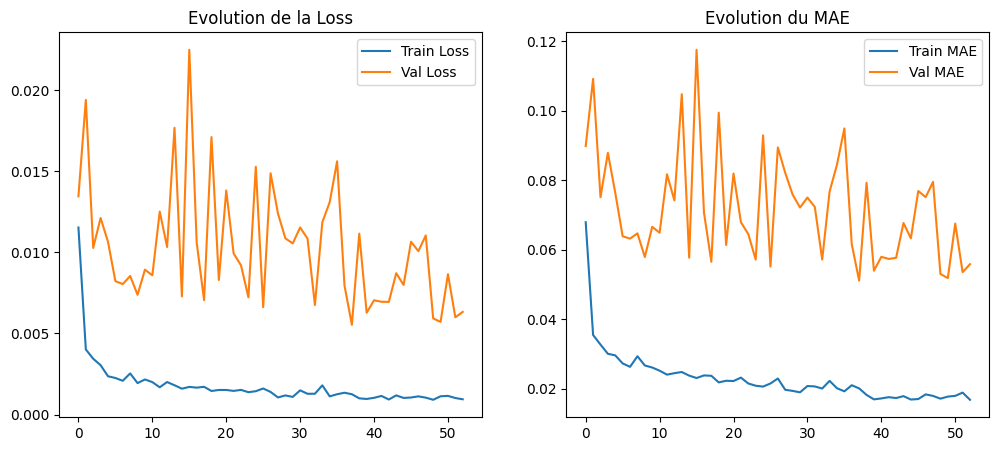

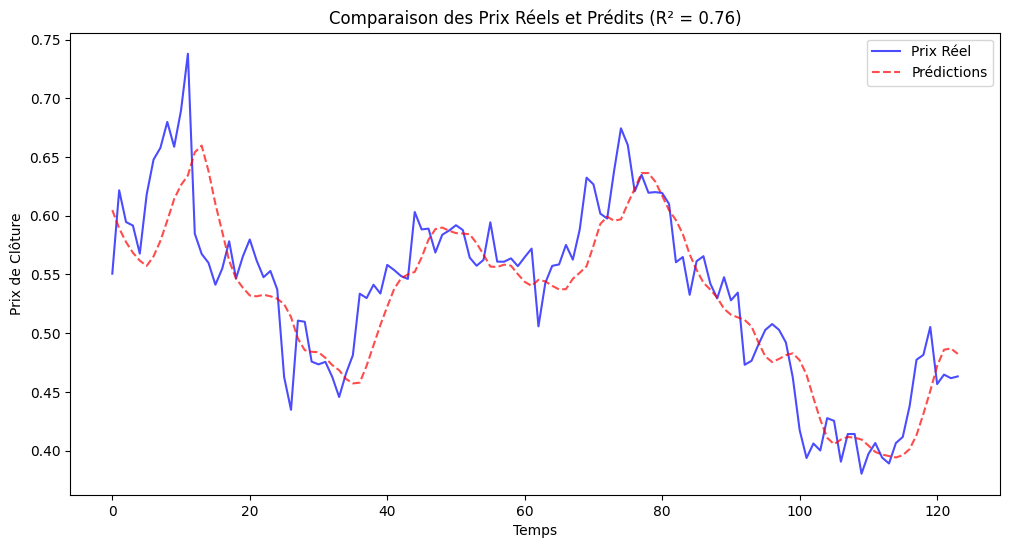

In [10]:
# Courbes d'apprentissage
def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Evolution de la Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title('Evolution du MAE')
    plt.legend()
    plt.show()

plot_history(history)

# Comparaison des prédictions vs réalité
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Prix Réel', color='blue', alpha=0.7)
plt.plot(y_pred_inv, label='Prédictions', color='red', linestyle='--', alpha=0.7)
plt.title(f"Comparaison des Prix Réels et Prédits (R² = {r2:.2f})")
plt.xlabel('Temps')
plt.ylabel('Prix de Clôture')
plt.legend()
plt.show()

Visualisations :

    Courbes de Loss/MAE :

        La loss en validation stagne après ~30 époques → l'early stopping a bien fonctionné.

    Prédictions vs Réalité :

        Les courbes devraient suivre grossièrement la même tendance (si R² > 0.7).

Améliorations Possibles

    Ajouter plus de features :

        Volume trading, indicateurs techniques supplémentaires (MACD, Bollinger Bands).

    Ajuster les hyperparamètres :

        sequence_length=30 pour capturer des tendances plus courtes.

        Réduire le nombre de neurones (32 au lieu de 64) pour réduire l'overfitting.

    Essayer un GRU :

        Variante plus simple que la LSTM, parfois plus efficace.



Conclusion

Votre modèle est déjà performant (R²=0.76), mais peut être amélioré. Les résultats montrent qu'il capture bien les tendances générales, mais peine sur les variations brusques (typique des marchés financiers).